<a href="https://colab.research.google.com/github/nagilla-jashwanth/language-translator-en-to-it/blob/main/language_translator_en_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

In [ ]:
!pip install tensorboard

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import math
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
from pathlib import Path
from typing import Any
from tqdm import tqdm
import warnings

In [ ]:
class InputEmbeddings(nn.Module):

    def __init__(self, d_model: int, vocab_size: int):
        super().__init__()
        self.d_model = d_model # 512 dim
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model) # PyTorch layer that converts integer indices to dense embeddings

    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len # Max sentence length
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self,x):
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False)
        return self.dropout(x)

In [ ]:
class LayerNormalization(nn.Module):

    def __init__(self, eps: float = 10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(1)) # scale the input data
        self.bias = nn.Parameter(torch.zeros(1)) # added to the input data

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        std = x.std(dim = -1, keepdim = True)
        return self.alpha * (x-mean) / (std + self.eps) + self.bias

In [ ]:
class FeedForwardBlock(nn.Module):

    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) # W1 & b1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) # W2 & b2

    def forward(self, x):
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

In [ ]:
class MultiHeadAttentionBlock(nn.Module):

    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.d_model = d_model
        self.h = h
        assert d_model % h == 0, 'd_model is not divisible by h'

        self.d_k = d_model // h

        self.w_q = nn.Linear(d_model, d_model) # W_q
        self.w_k = nn.Linear(d_model, d_model) # W_k
        self.w_v = nn.Linear(d_model, d_model) # W_v
        self.w_o = nn.Linear(d_model, d_model) # W_o

        self.dropout = nn.Dropout(dropout)

    @staticmethod
    def attention(query, key, value, mask, dropout: nn.Dropout):

        d_k = query.shape[-1]
        attention_scores = (query @ key.transpose(-2,-1)) / math.sqrt(d_k)

        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim = -1)
        if dropout is not None:
            attention_scores = dropout(attention_scores)

        return (attention_scores @ value), attention_scores

    def forward(self, q, k, v, mask):

        query = self.w_q(q) # Q' matrix
        key = self.w_k(k) # K' matrix
        value = self.w_v(v) # V' matrix

        # Splitting results into smaller matrices for the different heads

        query = query.view(query.shape[0], query.shape[1], self.h, self.d_k).transpose(1,2)
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2)

        # output and the attention scores
        x, self.attention_scores = MultiHeadAttentionBlock.attention(query, key, value, mask, self.dropout)

        # H matrix - concat all heads
        x = x.transpose(1, 2).contiguous().view(x.shape[0], -1, self.h * self.d_k)

        return self.w_o(x) # MH-A vector

In [ ]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization() # We use a normalization layer

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [ ]:
class EncoderBlock(nn.Module):

    def __init__(self, self_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()

        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(2)]) # 2 Residual Connections

    def forward(self, x, src_mask):
        # first residual connection for self-attention block
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, src_mask)) # Three x -> (query, key, and value ) + source mask

        # second residual connection for feed-forward block
        x = self.residual_connections[1](x, self.feed_forward_block)
        return x

In [ ]:
class Encoder(nn.Module):

    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers # Storing the EncoderBlocks
        self.norm = LayerNormalization() # Layer for the normalization of the output of the encoder layers

    def forward(self, x, mask):
        # Iterating over each EncoderBlock stored in self.layers
        for layer in self.layers:
            x = layer(x, mask) # Applying each EncoderBlock to the input tensor 'x'
        return self.norm(x) # Normalizing output

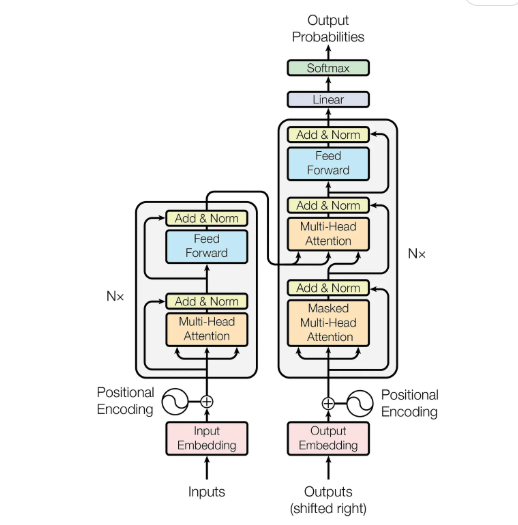

In [ ]:
class DecoderBlock(nn.Module):

    def __init__(self,  self_attention_block: MultiHeadAttentionBlock, cross_attention_block: MultiHeadAttentionBlock, feed_forward_block: FeedForwardBlock, dropout: float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)]) # List of three Residual Connections with dropout rate

    def forward(self, x, encoder_output, src_mask, tgt_mask):

        # Self-Attention block with query, key, and value plus the target language mask
        x = self.residual_connections[0](x, lambda x: self.self_attention_block(x, x, x, tgt_mask))

        # The Cross-Attention block using two 'encoder_ouput's for key and value plus the source language mask. It also takes in 'x' for Decoder queries
        x = self.residual_connections[1](x, lambda x: self.cross_attention_block(x, encoder_output, encoder_output, src_mask))

        # Feed-forward block with residual connections
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

In [ ]:
class Decoder(nn.Module):

    def __init__(self, layers: nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization() # Layer to normalize the output

    def forward(self, x, encoder_output, src_mask, tgt_mask):

        for layer in self.layers:
            # Applies each DecoderBlock to the input 'x' plus the encoder output and source and target masks
            x = layer(x, encoder_output, src_mask, tgt_mask)
        return self.norm(x) # Returns normalized output

In [ ]:
class ProjectionLayer(nn.Module):
    def __init__(self, d_model: int, vocab_size: int) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size) # Linear layer for projecting the feature space of 'd_model' to the output space of 'vocab_size'
    def forward(self, x):
        return torch.log_softmax(self.proj(x), dim = -1) # Applying the log Softmax function to the output

In [ ]:
class Transformer(nn.Module):

    def __init__(self, encoder: Encoder, decoder: Decoder, src_embed: InputEmbeddings, tgt_embed: InputEmbeddings, src_pos: PositionalEncoding, tgt_pos: PositionalEncoding, projection_layer: ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer

    # Encoder
    def encode(self, src, src_mask):
        src = self.src_embed(src)
        src = self.src_pos(src)
        return self.encoder(src, src_mask)

    # Decoder
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt)
        tgt = self.tgt_pos(tgt)

        # The target mask ensures that the model won't 'see' future elements of the sequence
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)

    # Applying Projection Layer with the Softmax function to the Decoder output
    def project(self, x):
        return self.projection_layer(x)

In [ ]:
def build_transformer(src_vocab_size: int, tgt_vocab_size: int, src_seq_len: int, tgt_seq_len: int, d_model: int = 512, N: int = 6, h: int = 8, dropout: float = 0.1, d_ff: int = 2048) -> Transformer:

    # Creating Embedding layers
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)

    # Creating Positional Encoding layers
    src_pos = PositionalEncoding(d_model, src_seq_len, dropout)
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)

    # Creating EncoderBlocks
    encoder_blocks = [] # Initial list of empty EncoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' EncoderBlocks (N = 6)
        encoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Self-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward

        # Combine layers into an EncoderBlock
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block) # Appending EncoderBlock to the list of EncoderBlocks
        # Creating DecoderBlocks
    decoder_blocks = [] # Initial list of empty DecoderBlocks
    for _ in range(N): # Iterating 'N' times to create 'N' DecoderBlocks (N = 6)
        decoder_self_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Self-Attention
        decoder_cross_attention_block = MultiHeadAttentionBlock(d_model, h, dropout) # Cross-Attention
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout) # FeedForward

        # Combining layers into a DecoderBlock
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block, feed_forward_block, dropout)
        decoder_blocks.append(decoder_block) # Appending DecoderBlock to the list of DecoderBlocks

        # Creating the Encoder and Decoder by using the EncoderBlocks and DecoderBlocks lists
        encoder = Encoder(nn.ModuleList(encoder_blocks))
        decoder = Decoder(nn.ModuleList(decoder_blocks))

        # Creating projection layer
        projection_layer = ProjectionLayer(d_model, tgt_vocab_size) # Map the output of Decoder to the Target Vocabulary Space

        # Creating the transformer by combining everything above
        transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)

        # Initialize the parameters
        for p in transformer.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

        return transformer # Assembled and initialized Transformer. Ready to be trained and validated!

In [ ]:
def build_tokenizer(config, ds, lang):

    # Crating a file path for the tokenizer
    tokenizer_path = Path(config['tokenizer_file'].format(lang))

    # Checking if Tokenizer already exists
    if not Path.exists(tokenizer_path):

        # If it doesn't exist, we create a new one
        tokenizer = Tokenizer(WordLevel(unk_token = '[UNK]')) # Initializing a new world-level tokenizer
        tokenizer.pre_tokenizer = Whitespace() # We will split the text into tokens based on whitespace

        # Creating a trainer for the new tokenizer
        trainer = WordLevelTrainer(special_tokens = ["[UNK]", "[PAD]",
                                                     "[SOS]", "[EOS]"], min_frequency = 2) # Defining Word Level strategy and special tokens

        # Training new tokenizer on sentences from the dataset and language specified
        tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer = trainer)
        tokenizer.save(str(tokenizer_path)) # Saving trained tokenizer to the file path specified at the beginning of the function
    else:
        tokenizer = Tokenizer.from_file(str(tokenizer_path)) # If the tokenizer already exist, we load it
    return tokenizer # Returns the loaded tokenizer or the trained tokenizer

In [ ]:
def get_all_sentences(ds, lang):
    for pair in ds:
        yield pair['translation'][lang]

In [ ]:
def get_ds(config):

    # Loading the train portion of the OpusBooks dataset.
    # The Language pairs will be defined in the 'config' dictionary we will build later
    ds_raw = load_dataset('opus_books', f'{config["lang_src"]}-{config["lang_tgt"]}', split = 'train')

    # Building or loading tokenizer for both the source and target languages
    tokenizer_src = build_tokenizer(config, ds_raw, config['lang_src'])
    tokenizer_tgt = build_tokenizer(config, ds_raw, config['lang_tgt'])

    # Splitting the dataset for training and validation
    train_ds_size = int(0.9 * len(ds_raw)) # 90% for training
    val_ds_size = len(ds_raw) - train_ds_size # 10% for validation
    train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size]) # Randomly splitting the dataset

    # Processing data with the BilingualDataset class, which we will define below
    train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])
    val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config['lang_src'], config['lang_tgt'], config['seq_len'])

    # Iterating over the entire dataset and printing the maximum length found in the sentences of both the source and target languages
    max_len_src = 0
    max_len_tgt = 0
    for pair in ds_raw:
        src_ids = tokenizer_src.encode(pair['translation'][config['lang_src']]).ids
        tgt_ids = tokenizer_src.encode(pair['translation'][config['lang_tgt']]).ids
        max_len_src = max(max_len_src, len(src_ids))
        max_len_tgt = max(max_len_tgt, len(tgt_ids))

    print(f'Max length of source sentence: {max_len_src}')
    print(f'Max length of target sentence: {max_len_tgt}')

    # Creating dataloaders for the training and validadion sets
    # Dataloaders are used to iterate over the dataset in batches during training and validation
    train_dataloader = DataLoader(train_ds, batch_size = config['batch_size'], shuffle = True) # Batch size will be defined in the config dictionary
    val_dataloader = DataLoader(val_ds, batch_size = 1, shuffle = True)

    return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt # Returning the DataLoader objects and tokenizers

In [ ]:
def casual_mask(size):
        # Creating a square matrix filled with ones
        mask = torch.triu(torch.ones(1, size, size), diagonal = 1).type(torch.int)
        return mask == 0

In [ ]:
class BilingualDataset(Dataset):

    # This takes in the dataset contaning sentence pairs, the tokenizers for target and source languages, and the strings of source and target languages
    # 'seq_len' defines the sequence length for both languages
    def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_len) -> None:
        super().__init__()

        self.seq_len = seq_len
        self.ds = ds
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang

        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id("[SOS]")], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id("[EOS]")], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id("[PAD]")], dtype=torch.int64)
    def __len__(self):
        return len(self.ds)

    # Using the index to retrive source and target texts
    def __getitem__(self, index: Any) -> Any:
        src_target_pair = self.ds[index]
        src_text = src_target_pair['translation'][self.src_lang]
        tgt_text = src_target_pair['translation'][self.tgt_lang]

        # Tokenizing source and target texts
        enc_input_tokens = self.tokenizer_src.encode(src_text).ids
        dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

        # Computing how many padding tokens need to be added to the tokenized texts
        # Source tokens
        enc_num_padding_tokens = self.seq_len - len(enc_input_tokens) - 2 # Subtracting the two '[EOS]' and '[SOS]' special tokens
        # Target tokens
        dec_num_padding_tokens = self.seq_len - len(dec_input_tokens) - 1 # Subtracting the '[SOS]' special token

        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')
        encoder_input = torch.cat(
            [
            self.sos_token, # inserting the '[SOS]' token
            torch.tensor(enc_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
            self.eos_token, # Inserting the '[EOS]' token
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )

        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]

        )

        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(dec_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                self.eos_token, # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype = torch.int64) # Adding padding tokens

            ]
        )
        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.seq_len
        assert decoder_input.size(0) == self.seq_len
        assert label.size(0) == self.seq_len

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input,
            'encoder_mask': (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int(),
            'decoder_mask': (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0).int() & casual_mask(decoder_input.size(0)),
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }



In [ ]:
def greedy_decode(model, source, source_mask, tokenizer_src, tokenizer_tgt, max_len, device):
    # Retrieving the indices from the start and end of sequences of the target tokens
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')
    eos_idx = tokenizer_tgt.token_to_id('[EOS]')

    # Computing the output of the encoder for the source sequence
    encoder_output = model.encode(source, source_mask)
    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(1,1).fill_(sos_idx).type_as(source).to(device)

    # Looping until the 'max_len', maximum length, is reached
    while True:
        if decoder_input.size(1) == max_len:
            break

        # Building a mask for the decoder input
        decoder_mask = casual_mask(decoder_input.size(1)).type_as(source_mask).to(device)

        # Calculating the output of the decoder
        out = model.decode(encoder_output, source_mask, decoder_input, decoder_mask)

        # Applying the projection layer to get the probabilities for the next token
        prob = model.project(out[:, -1])

        # Selecting token with the highest probability
        _, next_word = torch.max(prob, dim=1)
        decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)

        # If the next token is an End of Sentence token, we finish the loop
        if next_word == eos_idx:
            break

    return decoder_input.squeeze(0) # Sequence of tokens generated by the decoder

In [ ]:
def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_state, writer, num_examples=2):
    model.eval() # Setting model to evaluation mode
    count = 0 # Initializing counter to keep track of how many examples have been processed

    console_width = 80 # Fixed witdh for printed messages

    # Creating evaluation loop
    with torch.no_grad(): # Ensuring that no gradients are computed during this process
        for batch in validation_ds:
            count += 1
            encoder_input = batch['encoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)

            # Ensuring that the batch_size of the validation set is 1
            assert encoder_input.size(0) ==  1, 'Batch size must be 1 for validation.'

            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            model_out = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

            # Retrieving source and target texts from the batch
            source_text = batch['src_text'][0]
            target_text = batch['tgt_text'][0] # True translation
            model_out_text = tokenizer_tgt.decode(model_out.detach().cpu().numpy()) # Decoded, human-readable model output

            # Printing results
            print_msg('-'*console_width)
            print_msg(f'SOURCE: {source_text}')
            print_msg(f'TARGET: {target_text}')
            print_msg(f'PREDICTED: {model_out_text}')

            # After two examples, we break the loop
            if count == num_examples:
                break

In [ ]:
def get_model(config, vocab_src_len, vocab_tgt_len):

    # Loading model using the 'build_transformer' function.
    model = build_transformer(vocab_src_len, vocab_tgt_len, config['seq_len'], config['seq_len'], config['d_model'])
    return model

In [ ]:
# Define settings for building and training the transformer model
def get_config():
    return{
        'batch_size': 16,
        'num_epochs': 25,
        'lr': 10**-4,
        'seq_len': 350,
        'd_model': 512, # based on "Attention Is All You Need" paper.
        'lang_src': 'en',
        'lang_tgt': 'it',
        'model_folder': 'weights',
        'model_basename': 'tmodel_',
        'preload': None,
        'tokenizer_file': 'tokenizer_{0}.json',
        'experiment_name': 'runs/tmodel'
    }


# Function to construct the path for saving and retrieving model weights
def get_weights_file_path(config, epoch: str):
    model_folder = config['model_folder'] # Extracting model folder from the config
    model_basename = config['model_basename'] # Extracting the base name for model files
    model_filename = f"{model_basename}{epoch}.pt" # Building filename
    return str(Path('.')/ model_folder/ model_filename) # Combining current directory, the model folder, and the model filename

In [ ]:
def train_model(config):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device {device}")

    # Creating model directory to store weights
    Path(config['model_folder']).mkdir(parents=True, exist_ok=True)

    # Retrieving dataloaders and tokenizers for source and target languages
    train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
    model = get_model(config,tokenizer_src.get_vocab_size(), tokenizer_tgt.get_vocab_size()).to(device)
    writer = SummaryWriter(config['experiment_name'])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps = 1e-9)
    initial_epoch = 0
    global_step = 0

    # Checking if there is a pre-trained model to load
    # If true, loads it
    if config['preload']:
        model_filename = get_weights_file_path(config, config['preload'])
        print(f'Preloading model {model_filename}')
        state = torch.load(model_filename) # Loading model

        # Sets epoch to the saved in the state plus one, to resume from where it stopped
        initial_epoch = state['epoch'] + 1
        # Loading the optimizer state from the saved model
        optimizer.load_state_dict(state['optimizer_state_dict'])
        # Loading the global step state from the saved model
        global_step = state['global_step']

    # Initializing CrossEntropyLoss function for training. We ignore padding tokens when computing loss, as they are not relevant for the learning process.We also apply label_smoothing to prevent overfitting
    loss_fn = nn.CrossEntropyLoss(ignore_index = tokenizer_src.token_to_id('[PAD]'), label_smoothing = 0.1).to(device)

    for epoch in range(initial_epoch, config['num_epochs']):
        # Initializing an iterator over the training dataloader
        # We also use tqdm to display a progress bar
        batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch:02d}')
        for batch in batch_iterator:
            model.train() # Train the model

            # Loading input data and masks onto the GPU
            encoder_input = batch['encoder_input'].to(device)
            decoder_input = batch['decoder_input'].to(device)
            encoder_mask = batch['encoder_mask'].to(device)
            decoder_mask = batch['decoder_mask'].to(device)

            # Running tensors through the Transformer
            encoder_output = model.encode(encoder_input, encoder_mask)
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            proj_output = model.project(decoder_output)

            # Loading the target labels onto the GPU
            label = batch['label'].to(device)

            # Computing loss between model's output and true labels
            loss = loss_fn(proj_output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1))

            # Updating progress bar
            batch_iterator.set_postfix({f"loss": f"{loss.item():6.3f}"})

            writer.add_scalar('train loss', loss.item(), global_step)
            writer.flush()

            # backpropagation
            loss.backward()

            # Updating parameters based on the gradients
            optimizer.step()

            # Clearing the gradients to prepare for the next batch
            optimizer.zero_grad()

            global_step += 1 # Updating global step count
        run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device, lambda msg: batch_iterator.write(msg), global_step, writer)

        # Saving model
        model_filename = get_weights_file_path(config, f'{epoch:02d}')
        # Writting current model state to the 'model_filename'
        torch.save({
            'epoch': epoch, # Current epoch
            'model_state_dict': model.state_dict(),# Current model state
            'optimizer_state_dict': optimizer.state_dict(), # Current optimizer state
            'global_step': global_step # Current global step
        }, model_filename)




In [ ]:
if __name__ == '__main__':
    warnings.filterwarnings('ignore') # Filtering warnings
    config = get_config() # Retrieving config settings
    train_model(config) # Training model with the config arguments

NameError: name 'train_model' is not defined

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.3 MB/s eta 0:00:00


In [ ]:
import torchmetrics

def run_validation(model, validation_ds, tokenizer_src, tokenizer_tgt, max_len, device, print_msg, global_step, writer, num_examples=2):
    model.eval()
    count = 0
    # Size of the tensors
    source_texts = []
    expected = []
    predicted = []

    #Iterating over the validation dataset
    try:
        with torch.no_grad(): # Disabling gradient calculation
            for batch in validation_ds:

                count += 1
                encoder_input = batch['encoder_input'].to(device) # (B, Seq_Len)
                encoder_mask = batch['encoder_mask'].to(device) # (B, 1, 1, Seq_Len)

                # Ensure the batch size is 1 for the validation
                assert encoder_input.size(0) == 1, "Batch size must be 1 for validation"

                model_output = greedy_decode(model, encoder_input, encoder_mask, tokenizer_src, tokenizer_tgt, max_len, device)

                source_text = batch['src_text'][0]
                target_text = batch['tgt_text'][0]
                model_out_text = tokenizer_tgt.decode(model_output.tolist()) # model_output.tolist() for consistency with tokenizer_tgt.decode

                source_texts.append(source_text)
                expected.append(target_text)
                predicted.append(model_out_text)

                print_msg('-'*50)
                print_msg(f"{f'SOURCE: ':>12}{source_text}")
                print_msg(f"{f'TARGET: ':>12}{target_text}")
                print_msg(f"{f'PREDICTED: ':>12}{model_out_text}")

                if num_examples is not None and count == num_examples:
                    print_msg('-'*50)
                    break

    except Exception as e:
        print_msg(f"Validation error: {e}")

    # Evaluate the Character Error Rate (CER)
    # Compute the char error rate
    cer_metric = torchmetrics.CharErrorRate()
    cer = cer_metric(predicted, expected)

    # Compute the word error rate
    wer_metric = torchmetrics.WordErrorRate()
    wer = wer_metric(predicted, expected)

    # Compute the BLEU score
    bleu_metric = torchmetrics.BLEUScore()
    bleu = bleu_metric(predicted, expected)
    ans = (
    f"Final Validation Metrics:\n"
    f"  BLEU Score: {bleu.item():.4f}\n"
    f"  CER Score: {cer.item():.4f}\n"
    f"  WER Score: {wer.item():.4f}"
)


    if writer:
        writer.add_scalar('validation cer', cer, global_step)
        writer.add_scalar('validation wer', wer, global_step)
        writer.add_scalar('validation bleu', bleu, global_step)
        writer.flush()
    return ans


In [ ]:
if __name__ == '__main__':
    warnings.filterwarnings('ignore') # Filtering warnings
    config = get_config() # Retrieving config settings
    train_model(config) # Training model with the config arguments


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
config = get_config()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")

# Get dataloaders and tokenizers (this will build tokenizers if not existing)
train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)

vocab_src_len = tokenizer_src.get_vocab_size()
vocab_tgt_len = tokenizer_tgt.get_vocab_size()

model = get_model(config, vocab_src_len, vocab_tgt_len).to(device)

# Load the pre-trained weights
model_filename = "/content/drive/MyDrive/tmodel_23.pt"
state = torch.load(model_filename, map_location=torch.device('cpu'))
model.load_state_dict(state['model_state_dict'])
model.eval()

def translate_sentence(sentence: str):
    # Tokenize the source sentence
    enc_input_tokens = tokenizer_src.encode(sentence).ids

    # Add SOS and EOS tokens and pad to seq_len
    encoder_input = torch.cat(
        [
            torch.tensor([tokenizer_src.token_to_id("[SOS]")], dtype=torch.int64),
            torch.tensor(enc_input_tokens, dtype=torch.int64),
            torch.tensor([tokenizer_src.token_to_id("[EOS]")], dtype=torch.int64),
            torch.tensor([tokenizer_src.token_to_id("[PAD]")] * (config['seq_len'] - len(enc_input_tokens) - 2), dtype=torch.int64),
        ]
    ).to(device)
    encoder_mask = (encoder_input != tokenizer_src.token_to_id("[PAD]")).unsqueeze(0).unsqueeze(0).int().to(device)

    # Perform greedy decoding
    model_output = greedy_decode(model, encoder_input.unsqueeze(0), encoder_mask, tokenizer_src, tokenizer_tgt, config['seq_len'], device)

    # Decode the output
    translated_text = tokenizer_tgt.decode(model_output.tolist())

    print(f"SOURCE: {sentence}")
    print(f"TRANSLATED: {translated_text}")

# Example usage:
translate_sentence("I am a student.")
translate_sentence("The quick brown fox jumps over the lazy dog.")


Using device cpu
Max length of source sentence: 309
Max length of target sentence: 274
SOURCE: I am a student.
TRANSLATED: Sono un compagno .
SOURCE: The quick brown fox jumps over the lazy dog.
TRANSLATED: Il , il , si sdraiò sul cane .


In [ ]:
from torch.utils.tensorboard import SummaryWriter

print("Calculating BLEU score and other metrics on the validation data (as a proxy for test data)...")
writer_for_test = SummaryWriter(config['experiment_name'] + '_test_run')

global_state = {'step': 0}
ans=run_validation(model, val_dataloader, tokenizer_src, tokenizer_tgt, config['seq_len'], device,
               lambda msg: print(msg), global_step=global_state['step'], writer=writer_for_test, num_examples=None)

writer_for_test.close()
print("BLEU score, CER, and WER calculation complete. Check TensorBoard logs or console output for results.",ans)

Streaming output truncated to the last 5000 lines.
--------------------------------------------------
    SOURCE: But for an oven I was indeed in great pain.
    TARGET: Finalmente per supplire anche a questa mancanza, ecco qual rimedio inventai.
 PREDICTED: Finalmente per supplire anche a questa mancanza , ecco qual rimedio inventai .
--------------------------------------------------
    SOURCE: 'Well, what of that? I'll call at the bank and get some...
    TARGET: — Va bene, passerò a prenderne in banca.
 PREDICTED: — Va bene , passerò a prenderne in banca .
--------------------------------------------------
    SOURCE: It was a great comfort to me afterwards that I did so, for not one grain of what I sowed this time came to anything: for the dry months following, the earth having had no rain after the seed was sown, it had no moisture to assist its growth, and never came up at all till the wet season had come again, and then it grew as if it had been but newly sown.
    TARGET: Com

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `CharErrorRate` from `torchmetrics` was deprecated and will be removed in 2.0. Import `CharErrorRate` from `torchmetrics.text` instead.
  _future_warning(
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `WordErrorRate` from `torchmetrics` was deprecated and will be removed in 2.0. Import `WordErrorRate` from `torchmetrics.text` instead.
  _future_warning(
/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `BLEUScore` from `torchmetrics` was deprecated and will be removed in 2.0. Import `BLEUScore` from `torchmetrics.text` instead.
  _future_warning(


BLEU score, CER, and WER calculation complete. Check TensorBoard logs or console output for results. Final Validation Metrics:
  BLEU Score: 0.0000
  CER Score: 0.2639
  WER Score: 0.5848
